This notebook was created by Donna Faith Go.

For reference, I used [this website](https://medium.com/@golnaz.hosseini/beginner-tutorial-image-classification-using-pytorch-63f30dcc071c) to learn about CNNs with pytorch.

## Imports

In [1]:
# import the necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import random
import time
import copy

# modelling the CNN
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as ptransforms

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## Code

In [2]:
TRANSFORMS = ptransforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter()
])

batch_size = 32
 
train = torchvision.datasets.CIFAR10(root="./data",
                                        train=True,
                                        transform=TRANSFORMS,
                                        download=True
                                        )

train_dl = DataLoader(train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

classes = train.classes

In [3]:
test = torchvision.datasets.CIFAR10(root="./data", 
                                 train=False, 
                                 transform=TRANSFORMS, 
                                 download=True)

test_dl = DataLoader(test, 
                    batch_size=1, 
                    shuffle=False, 
                    num_workers=0)

dataloaders ={'train': train_dl, 'valid': test_dl, 'test': test_dl}

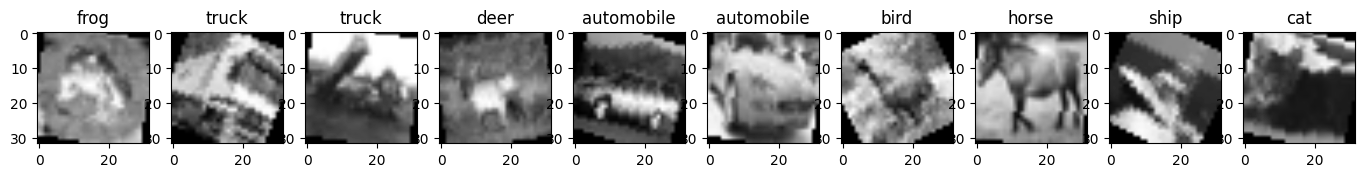

In [4]:
N_IMAGES = 10

fig, ax = plt.subplots(1, N_IMAGES, figsize=(17,7))

for i in range(N_IMAGES):
    im, lbl = train[i]

    ax[i].imshow(im[0,:,:], 'gray', interpolation='bilinear')
    ax[i].set_title(f'{classes[lbl]}')

In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.layer1 = self.ConvModule(in_features=3, out_features=64)      #16,16
        self.layer2 = self.ConvModule(in_features=64, out_features=128)    #8,8
        self.layer3 = self.ConvModule(in_features=128, out_features=256)   #4,4
        self.layer4 = self.ConvModule(in_features=256, out_features=512)   #2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,10)) #,
                                        # nn.Softmax())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
    def ConvModule(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)

In [6]:
learning_rate = 0.001
num_epochs = 35
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    history_dict = {'train_loss':train_loss_history, 'train_accuracy':train_acc_history,
                    'test_loss':test_loss_history, 'test_accuracy':test_acc_history}
    return model, history_dict

Epoch 1/35
train Loss: 1.4694, Acc: 0.4647
test Loss: 1.2075, Acc: 0.5669

Epoch 2/35
train Loss: 1.1159, Acc: 0.5990
test Loss: 1.0062, Acc: 0.6409

Epoch 3/35
train Loss: 0.9765, Acc: 0.6511
test Loss: 0.9436, Acc: 0.6741

Epoch 4/35
train Loss: 0.8845, Acc: 0.6870
test Loss: 0.8765, Acc: 0.6919

Epoch 5/35
train Loss: 0.8198, Acc: 0.7109
test Loss: 0.8637, Acc: 0.6958

Epoch 6/35
train Loss: 0.7641, Acc: 0.7310
test Loss: 0.7781, Acc: 0.7293

Epoch 7/35
train Loss: 0.7226, Acc: 0.7433
test Loss: 0.8096, Acc: 0.7121

Epoch 8/35
train Loss: 0.6865, Acc: 0.7585
test Loss: 0.7640, Acc: 0.7313

Epoch 9/35
train Loss: 0.6586, Acc: 0.7694
test Loss: 0.7940, Acc: 0.7208

Epoch 10/35
train Loss: 0.6295, Acc: 0.7789
test Loss: 0.7272, Acc: 0.7463

Epoch 11/35
train Loss: 0.6016, Acc: 0.7857
test Loss: 0.7443, Acc: 0.7453

Epoch 12/35
train Loss: 0.5799, Acc: 0.7981
test Loss: 0.6886, Acc: 0.7617

Epoch 13/35
train Loss: 0.5632, Acc: 0.8018
test Loss: 0.6723, Acc: 0.7632

Epoch 14/35
train Los

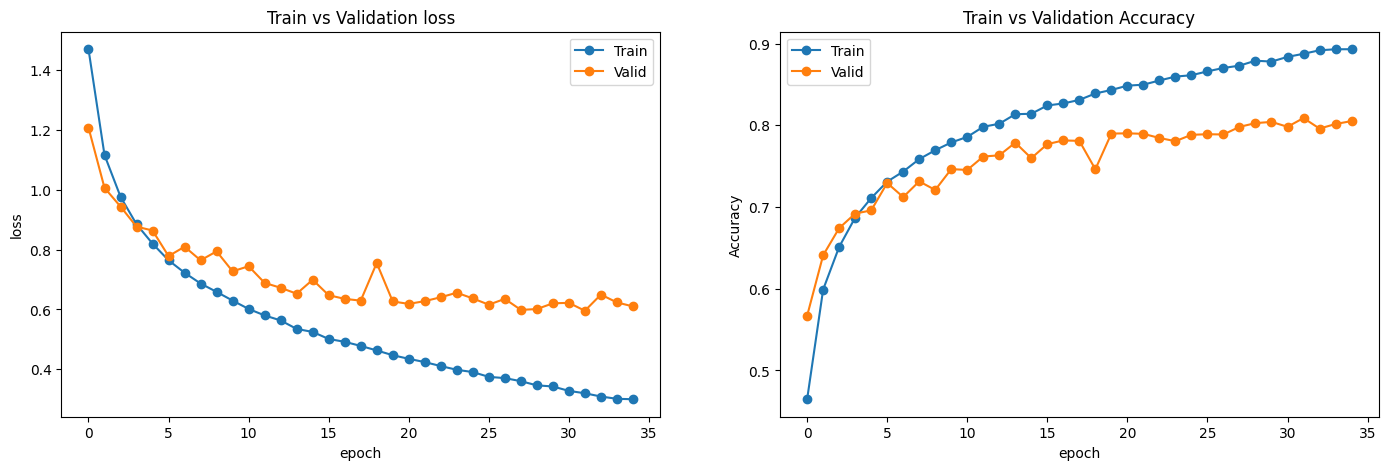

In [7]:
model, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs)

plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(hist['train_loss'],'-o')
plt.plot(hist['test_loss'],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation loss')

plt.subplot(122)
plt.plot(hist['train_accuracy'],'-o')
plt.plot(hist['test_accuracy'],'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation Accuracy')

 
plt.show()